## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# import matplotlib.pyplot as plt
# import seaborn as sns
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
import seaborn as sns
import statsmodels.api as sm
from sklearn.manifold import TSNE
import xgboost as xgb

/Users/pruek/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Read in all tables and visualize.

In [78]:
train = pd.read_csv('training_set.csv')
test = pd.read_csv('test_set.csv')

## Convert dow and hod to number

In [81]:
train.head()

,X,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,part_of_day,department,aisle
0,0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,4,4,Wednesday,9,Late_Morning,dairy eggs,yogurt
1,1,98,43654,3,1,Whole Milk Greek Blended Vanilla Bean Yogurt,120,16,56463,41,3,Tuesday,14,Early_Morning,dairy eggs,yogurt
2,2,170,8153,6,0,Plain Non-Fat Greek Yogurt,120,16,182389,7,0,Saturday,14,Early_Afternoon,dairy eggs,yogurt
3,3,631,9203,13,1,Dairy Free Coconut Milk Raspberry Yogurt Alter...,120,16,184099,7,3,Tuesday,30,Late_Morning,dairy eggs,yogurt
4,6,915,19977,11,0,Light & Fit Greek Cherry Yogurt,120,16,166117,4,1,Sunday,30,Late_Afternoon,dairy eggs,yogurt


In [95]:
# days = {'Saturday':0 , 'Sunday':1, 'Monday':2 ,'Tuesday':3 , 'Wednesday':4 , 'Thursday':5, 'Friday':6}
# train['order_dow'] = [ days[item1] for item1 in train['order_dow'] ]
# test['order_dow'] = [ days[item2] for item2 in test['order_dow'] ]
# hours = list(range(24))
# hod = {datetime.time(hours).strftime("%I:00 %p"):hours for hours in hours}
# train['order_hour_of_day'] = [ hod[item] for item in train['order_hour_of_day'] ]
# test['order_hour_of_day'] = [ hod[item] for item in test['order_hour_of_day'] ]
drop_list = ['X', 'order_hour_of_day']
train = train.drop(drop_list,axis=1)
test = test.drop(drop_list,axis=1)
train.info()
train.head()

KeyError: "['X', 'order_hour_of_day'] not found in axis"

## Check Dataset

In [96]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415385 entries, 0 to 415384
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   order_id                415385 non-null  int64 
 1   product_id              415385 non-null  int64 
 2   add_to_cart_order       415385 non-null  int64 
 3   reordered               415385 non-null  int64 
 4   product_name            415385 non-null  object
 5   aisle_id                415385 non-null  int64 
 6   department_id           415385 non-null  int64 
 7   user_id                 415385 non-null  int64 
 8   order_number            415385 non-null  int64 
 9   order_dow               415385 non-null  int64 
 10  days_since_prior_order  415385 non-null  int64 
 11  part_of_day             415385 non-null  object
 12  department              415385 non-null  object
 13  aisle                   415385 non-null  object
dtypes: int64(10), object(4)
memory usage

## Feature Engineering

In [98]:
from collections import defaultdict
from sklearn import preprocessing

u_dict = defaultdict(dict)
p_dict = defaultdict(dict)
up_dict = defaultdict(dict)
a_dict = defaultdict(dict)
d_dict = defaultdict(dict)

print('initial test: ', test_plus.shape[0])
print('initial train: ',train_plus.shape[0])

#up_nb_reordered =  
u_dict['up_nb_reordered'] = train.groupby('product_id')['reordered'].sum().rename('up_nb_reordered')
# u_dict['up_nb_reordered'] = train.groupby(['product_id','user_id'])['reordered'].nunique().rename('up_nb_reordered')
# u_dict['up_nb_reordered'].head()
#up_tot_purchase
u_dict['up_tot_purchase'] = train.groupby('user_id')['product_id'].count().rename('up_tot_purchase')

# number of total items a given user has purchased which are reorders
u_dict['up_tot_reordered'] = train.groupby('user_id')['reordered'].sum().rename('up_tot_reordered')

# number of orders a given user has placed
u_dict['u_order_no'] = train.groupby('user_id')['order_number'].max().rename('u_order_no')

# mean of user cart size
u_dict['u_max_cart'] = train.groupby('user_id')['add_to_cart_order'].max().rename('u_max_cart')
u_dict['u_mean_cart'] = u_dict['u_max_cart'].div(u_dict['u_order_no']).rename('u_mean_cart')

# mean dow
u_dict['u_mean_dow'] = train.groupby('user_id')['order_dow'].mean().rename('u_mean_dow')

# reorder ratio
u_dict['u_reorder_ratio'] = train.groupby('user_id')['reordered'].mean().astype('float16').rename('u_reorder_ratio')

#pd.concat([u_dict[k] for k in u_dict.keys()], axis=1)
train_plus = pd.merge(train, u_dict['up_nb_reordered'], on=['product_id'])
train_plus = pd.merge(train_plus, u_dict['up_tot_purchase'], on=['user_id'])
train_plus = pd.merge(train_plus, u_dict['up_tot_reordered'], on=['user_id'])
train_plus = pd.merge(train_plus, u_dict['u_mean_dow'], on=['user_id'])
train_plus = pd.merge(train_plus, u_dict['u_order_no'], how='left', on=['user_id'])
train_plus = pd.merge(train_plus, u_dict['u_mean_cart'], how='left', on=['user_id'])
train_plus = pd.merge(train_plus, u_dict['u_max_cart'], how='left', on=['user_id'])

# train_plus = pd.merge(train_plus, u_dict['u_reorder_ratio'], how='left', on=['user_id'])

test_plus = pd.merge(test, u_dict['up_nb_reordered'], on=['product_id'], how='left')
# print(test_plus.shape[0])
test_plus = pd.merge(test_plus, u_dict['up_tot_purchase'], on=['user_id'], how='left')
# print(test_plus.shape[0])
test_plus = pd.merge(test_plus, u_dict['up_tot_reordered'], on=['user_id'], how='left')
# print(test_plus.shape[0])
test_plus = pd.merge(test_plus, u_dict['u_mean_dow'], on=['user_id'], how='left')
# print(test_plus.isnull().sum())
print(test_plus.shape[0])
test_plus = pd.merge(test_plus, u_dict['u_order_no'], how='left', on=['user_id'])
# print(test_plus.shape[0])
test_plus = pd.merge(test_plus, u_dict['u_mean_cart'], how='left', on=['user_id'])
print(test_plus.shape[0])
test_plus = pd.merge(test_plus, u_dict['u_max_cart'], how='left', on=['user_id'])
# test_plus = pd.merge(test_plus, u_dict['u_reorder_ratio'], how='left', on=['user_id'])
# print(test_plus.isnull().sum())


#product reorder ratio
p_dict['p_reorder_ratio'] = train.groupby('product_id')['reordered'].mean().astype('float16').rename('p_reorder_ratio')

#number of purchaser
max_puser = np.max(train.groupby('product_id')['user_id'].nunique())
p_dict['p_user'] = train.groupby('product_id')['user_id'].nunique().div(max_puser).rename('p_user')



train_plus = pd.merge(train_plus, p_dict['p_reorder_ratio'], on='product_id')
train_plus = pd.merge(train_plus, p_dict['p_user'], on='product_id')

test_plus = pd.merge(test_plus, p_dict['p_reorder_ratio'], on='product_id', how='left')
print(test_plus.shape[0])
test_plus = pd.merge(test_plus, p_dict['p_user'], on='product_id', how='left')

#user product reorder ratio
up_dict['up_reorder_ratio'] = train.groupby(['user_id','product_id'])['reordered'].sum().div(u_dict['u_order_no']).rename('up_reorder_ratio')

train_plus = pd.merge(train_plus, up_dict['up_reorder_ratio'].groupby('product_id').sum(), on='product_id')
print(test_plus.shape[0])
test_plus = pd.merge(test_plus, up_dict['up_reorder_ratio'].groupby('product_id').sum(), on='product_id', how='left')
# test_plus = pd.merge(test_plus, up_dict['up_reorder_ratio'], on=['user_id','product_id'], how='left')
# test_plus.info()

tot_order = train.groupby('order_id')['reordered'].sum().shape[0]
print(tot_order)

a_dict['a_reorder_ratio'] =  train.groupby('aisle_id')['reordered'].sum().div(tot_order).astype('float16').rename('a_reorder_ratio')
a_dict['a_count'] =  train.groupby('aisle_id')['aisle'].count().rename('a_reorder_ratio')

train_plus = pd.merge(train_plus, a_dict['a_reorder_ratio'], on='aisle_id')
print(test_plus.shape[0])
test_plus = pd.merge(test_plus, a_dict['a_reorder_ratio'], on='aisle_id',how='left')


d_dict['d_reorder_ratio'] =  train.groupby('department_id')['reordered'].sum().div(tot_order).astype('float16').rename('d_reorder_ratio')
# d_dict['d_reorder_ratio'] = d_dict['d_reorder_ratio']/tot_order

# train_plus = pd.merge(train_plus, d_dict['d_reorder_ratio'], on='department_id')
# test_plus = pd.merge(test_plus, d_dict['d_reorder_ratio'], on='department_id')


# d_dict['d_reorder_ratio'] =  train.groupby('department_id')['reordered'].sum().div(tot_order).astype('float16').rename('d_reorder_ratio')

# train_plus = pd.merge(train_plus, a_dict['a_count'], on='aisle_id')
# test_plus = pd.merge(test_plus, a_dict['a_count'], on='aisle_id')

# train_plus.loc[train_plus['order_number'] > 1, "first_order"] = 1
# train_plus.loc[train_plus['order_number'] <= 1, "first_order"] = 0

# test_plus.loc[test_plus['order_number'] > 1, "first_order"] = 1
# test_plus.loc[test_plus['order_number'] <= 1, "first_order"] = 0

print('Test After:',test_plus.shape[0])
print('Train After:',train_plus.shape[0])

#print(test_plus.isnull().values.any())
test_plus = test_plus.fillna(0)
print(test_plus.isnull().values.any())

train_plus.info()
test_plus.info()


initial test:  415385
initial train:  969232
415385
415385
415385
415385
128278
415385
Test After: 415385
Train After: 969232
False
<class 'pandas.core.frame.DataFrame'>
Int64Index: 969232 entries, 0 to 969231
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                969232 non-null  int64  
 1   product_id              969232 non-null  int64  
 2   add_to_cart_order       969232 non-null  int64  
 3   reordered               969232 non-null  int64  
 4   product_name            969232 non-null  object 
 5   aisle_id                969232 non-null  int64  
 6   department_id           969232 non-null  int64  
 7   user_id                 969232 non-null  int64  
 8   order_number            969232 non-null  int64  
 9   order_dow               969232 non-null  int64  
 10  days_since_prior_order  969232 non-null  int64  
 11  part_of_day             969232 non-null  object 
 

## Visualize the data

In [99]:
train_plus.info()
train_plus.sample(n=10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969232 entries, 0 to 969231
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                969232 non-null  int64  
 1   product_id              969232 non-null  int64  
 2   add_to_cart_order       969232 non-null  int64  
 3   reordered               969232 non-null  int64  
 4   product_name            969232 non-null  object 
 5   aisle_id                969232 non-null  int64  
 6   department_id           969232 non-null  int64  
 7   user_id                 969232 non-null  int64  
 8   order_number            969232 non-null  int64  
 9   order_dow               969232 non-null  int64  
 10  days_since_prior_order  969232 non-null  int64  
 11  part_of_day             969232 non-null  object 
 12  department              969232 non-null  object 
 13  aisle                   969232 non-null  object 
 14  up_nb_reordered     

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,...,up_tot_purchase,up_tot_reordered,u_mean_dow,u_order_no,u_mean_cart,u_max_cart,p_reorder_ratio,p_user,up_reorder_ratio,a_reorder_ratio
208759,1132498,47209,1,0,Organic Hass Avocado,24,4,86384,49,6,...,10,8,6.0,49,0.244898,12,0.827637,0.389262,380.417733,0.605469
552268,1899919,14715,4,1,Coconut Water,98,7,41668,33,5,...,6,3,5.0,33,0.212121,7,0.644043,0.021202,18.850392,0.047211
166794,96300,48775,6,0,Organic Red Cabbage,83,4,58768,23,3,...,11,9,3.0,23,0.695652,16,0.485840,0.032337,17.316144,0.497559
894321,3026553,43975,20,0,Rice Crusted Fish Sticks,129,1,128292,4,4,...,16,4,4.0,4,5.250000,21,0.222168,0.000686,0.170455,0.026398
912050,2243586,2309,8,0,Organic Ground Flaxseed,47,11,139926,12,0,...,17,14,0.0,12,2.000000,24,0.338379,0.004957,1.360685,0.003361
610089,761504,25584,18,1,Yellow Corn Tortillas,128,3,26604,6,2,...,21,18,2.0,6,4.666667,28,0.541504,0.003661,2.822660,0.025452
646853,3328835,43638,7,1,Butter Flavor Movie Theater Microwave Popcorn,23,19,42581,6,1,...,7,6,1.0,6,1.666667,10,0.520996,0.003661,2.962510,0.022690
380881,1015302,14355,9,1,Organic Beef Bone Broth,69,15,160681,30,0,...,7,6,0.0,30,0.366667,11,0.586426,0.006635,4.015337,0.037170
114740,1072756,19048,8,1,Organic Butternut Squash,83,4,22010,5,0,...,8,4,0.0,5,3.200000,16,0.448730,0.037218,18.640963,0.497559
255095,1529977,24852,3,1,Banana,24,4,3358,29,0,...,5,4,0.0,29,0.241379,7,0.886230,1.000000,1170.269943,0.605469


In [100]:
test_plus.info()
test_plus.sample(n=10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415385 entries, 0 to 415384
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                415385 non-null  int64  
 1   product_id              415385 non-null  int64  
 2   add_to_cart_order       415385 non-null  int64  
 3   reordered               415385 non-null  int64  
 4   product_name            415385 non-null  object 
 5   aisle_id                415385 non-null  int64  
 6   department_id           415385 non-null  int64  
 7   user_id                 415385 non-null  int64  
 8   order_number            415385 non-null  int64  
 9   order_dow               415385 non-null  int64  
 10  days_since_prior_order  415385 non-null  int64  
 11  part_of_day             415385 non-null  object 
 12  department              415385 non-null  object 
 13  aisle                   415385 non-null  object 
 14  up_nb_reordered     

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,...,up_tot_purchase,up_tot_reordered,u_mean_dow,u_order_no,u_mean_cart,u_max_cart,p_reorder_ratio,p_user,up_reorder_ratio,a_reorder_ratio
360697,1880106,48230,5,0,Soft Taco Size White Flour Tortillas,128,3,96267,15,4,...,6.0,4.0,4.0,15.0,0.800000,12.0,0.598145,0.007779,4.840501,0.025452
106557,3125065,34824,7,1,Organic Sweet Onion,83,4,66937,49,1,...,12.0,10.0,1.0,49.0,0.306122,15.0,0.449463,0.006788,3.390272,0.497559
215545,1248937,4002,8,1,Mango Ginger + Carrot 100% Fruit & Vegetable J...,31,7,161801,9,1,...,19.0,12.0,1.0,9.0,2.777778,25.0,0.000000,0.000000,0.000000,0.082825
149373,2960673,47209,1,0,Organic Hass Avocado,24,4,186327,8,6,...,4.0,1.0,6.0,8.0,0.625000,5.0,0.827637,0.389262,380.417733,0.605469
234120,1239870,7748,22,0,Medium Roast Cafe Domingo Ground,26,7,200690,4,0,...,13.0,6.0,0.0,4.0,4.500000,18.0,0.625000,0.001220,1.247380,0.028687
30913,2820797,10132,6,1,Organic American Cheese Singles,21,16,173075,15,6,...,16.0,10.0,6.0,15.0,1.800000,27.0,0.735352,0.034854,28.266873,0.134888
411118,2865482,41003,14,0,"Sesame Oil, Toasted",66,6,163515,33,5,...,9.0,5.0,5.0,33.0,0.393939,13.0,0.000000,0.000915,0.000000,0.013512
27456,1887316,15287,1,1,Sliced White American Cheese,21,16,117830,10,3,...,17.0,7.0,3.0,10.0,2.000000,20.0,0.750000,0.001220,1.528005,0.134888
133042,1703508,26604,13,0,Organic Blackberries,24,4,193340,39,6,...,12.0,5.0,6.0,39.0,0.487179,19.0,0.650879,0.149634,110.826723,0.605469
226182,1397693,47141,2,1,Cola,77,7,76289,10,0,...,14.0,9.0,0.0,10.0,2.200000,22.0,0.708008,0.030811,28.999064,0.057587


## Add Categorical Features

In [124]:
#Add order dow
train_new = pd.get_dummies(train_plus, columns=['order_dow'], drop_first=True)
test_new = pd.get_dummies(test_plus, columns=['order_dow'], drop_first=True)

#Add department
train_new = pd.get_dummies(train_new, columns=['department'], drop_first=True)
test_new = pd.get_dummies(test_new, columns=['department'], drop_first=True)

#Part of day
train_new = pd.get_dummies(train_new, columns=['part_of_day'], drop_first=True)
test_new = pd.get_dummies(test_new, columns=['part_of_day'], drop_first=True)


train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969232 entries, 0 to 969231
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     969232 non-null  int64  
 1   product_id                   969232 non-null  int64  
 2   add_to_cart_order            969232 non-null  int64  
 3   reordered                    969232 non-null  int64  
 4   product_name                 969232 non-null  object 
 5   aisle_id                     969232 non-null  int64  
 6   department_id                969232 non-null  int64  
 7   user_id                      969232 non-null  int64  
 8   order_number                 969232 non-null  int64  
 9   days_since_prior_order       969232 non-null  int64  
 10  aisle                        969232 non-null  object 
 11  up_nb_reordered              969232 non-null  int64  
 12  up_tot_purchase              969232 non-null  int64  
 13 

## Drop unnecessary features

In [126]:
# train_new = train_plus.drop(['order_id','reordered',  'user_id', 'department' , 'aisle', 'aisle_id',  'product_name', 'product_id', 'order_number'], axis=1)
# test_new = test_plus.drop(['order_id','reordered',  'user_id', 'department','aisle', 'aisle_id', 'product_name', 'product_id', 'order_number' ], axis=1)

#  0   order_id                     415385 non-null  int64  
#  1   product_id                   415385 non-null  int64  
#  2   add_to_cart_order            415385 non-null  int64  
#  3   reordered                    415385 non-null  int64  
#  4   product_name                 415385 non-null  object 
#  5   aisle_id                     415385 non-null  int64  
#  6   user_id                      415385 non-null  int64  
#  7   order_number                 415385 non-null  int64  
#  8   days_since_prior_order       415385 non-null  int64  
#  9   department                   415385 non-null  object 
#  10  aisle                        415385 non-null  object 


drop_list = ['order_id','product_id', 'reordered', 'product_name', 'aisle', 'aisle_id', 'user_id', 'department_id','order_number']

train_new2 = train_new.drop(drop_list, axis=1)
test_new2 = test_new.drop(drop_list, axis=1)


train_new2.info()
test_new2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969232 entries, 0 to 969231
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   add_to_cart_order            969232 non-null  int64  
 1   days_since_prior_order       969232 non-null  int64  
 2   up_nb_reordered              969232 non-null  int64  
 3   up_tot_purchase              969232 non-null  int64  
 4   up_tot_reordered             969232 non-null  int64  
 5   u_mean_dow                   969232 non-null  float64
 6   u_order_no                   969232 non-null  int64  
 7   u_mean_cart                  969232 non-null  float64
 8   u_max_cart                   969232 non-null  int64  
 9   p_reorder_ratio              969232 non-null  float16
 10  p_user                       969232 non-null  float64
 11  up_reorder_ratio             969232 non-null  float64
 12  a_reorder_ratio              969232 non-null  float16
 13 

## Function for XGBoost model

In [169]:
# function to run the xgboost model #
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
#         params["objective"] = "binary:logistic"
#         params['eval_metric'] = 'logloss'
#         params["eta"] = 0.05
#         params["subsample"] = 0.7
#         params["min_child_weight"] = 10
#         params["colsample_bytree"] = 0.7
#         params["max_depth"] = 12
#         params["silent"] = 1
#         params["seed"] = seed_val
#         num_rounds = 1000
        
        
        params["eta"] = 0.1
        params["max_depth"] = 6
        params["objective"] = 'multi:softprob'  
        params['num_class'] =  2 
        params["silent"] = 1
        params['eval_metric'] = 'auc'
        steps = 120
        
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(params, xgtrain, steps, watchlist, verbose_eval=2)
        
        pred_test_y = model.predict(xgtest)

#         if test_y is not None:
#                 xgtest = xgb.DMatrix(test_X, label=test_y)
#                 watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
#                 model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
#         else:
#                 xgtest = xgb.DMatrix(test_X)
#                 model = xgb.train(plst, xgtrain, num_rounds)

#         pred_test_y = model.predict(xgtest)
        return pred_test_y

## Run XGBoost

In [170]:

x_train, x_val = train_new2, test_new2
y_train, y_val = train_plus['reordered'], test_plus['reordered']

print(x_val.shape)
print(x_train.shape)
print(y_val.shape)
print(y_train.shape)
y_pred = runXGB(x_train, y_train, x_val, y_val[:,np.newaxis])
y_pred_label = np.argmax(y_pred, axis=1)


(415385, 45)
(969232, 45)
(415385,)
(969232,)


/var/folders/t_/kzhc7n6x0cl0zzbn6xcs39dr0000gn/T/ipykernel_71274/1535321826.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = runXGB(x_train, y_train, x_val, y_val[:,np.newaxis])


[21:05:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.84919	test-auc:0.75097
[2]	train-auc:0.86746	test-auc:0.76636
[4]	train-auc:0.87595	test-auc:0.77493
[6]	train-auc:0.87737	test-auc:0.77674
[8]	train-auc:0.88083	test-auc:0.78139
[10]	train-auc:0.88238	test-auc:0.78118
[12]	train-auc:0.88428	test-auc:0.78181
[14]	train-auc:0.88555	test-auc:0.78306
[16]	train-auc:0.88630	test-auc:0.78331
[18]	train-auc:0.88668	test-auc:0.78394
[20]	train-auc:0.88705	test-auc:0.78327
[22]	train-auc:0.88759	test-auc:0.78322
[24]	train-auc:0.88807	test-auc:0.78320
[26]	train-auc:0.888

## Evaluate Performance

(2.5, -0.5)

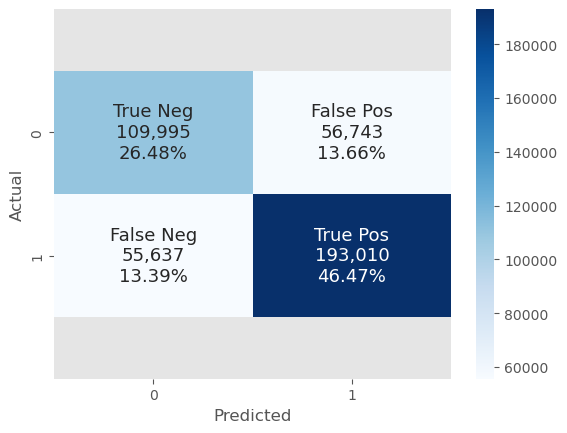

In [163]:
###Confusion Matrix

from sklearn import metrics

cf_matrix = metrics.confusion_matrix(y_val, y_pred_label)
con_mat = pd.crosstab(y_val, y_pred_label, rownames=['Actual'], colnames=['Predicted'])
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{:,}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={'size':13})
plt.xlabel('Predicted')
plt.ylabel('Actual')
# fix for mpl bug that cuts off top/bottom of seaborn viz
bottom, top = plt.ylim() # discover the values for bottom and top
bottom += 0.5 # Add 0.5 to the bottom
top -= 0.5 # Subtract 0.5 from the top
plt.ylim(bottom, top) # update the ylim(bottom, top) values

[0.23226792 0.8417401  0.7667692  ... 0.97130305 0.42995462 0.9807493 ]
Accuracy: 0.7294558060594388
Precision: 0.7728035298875289
Recall: 0.7762410163806521
F1: 0.7745184590690208
AUC Score: 0.7830179834341796


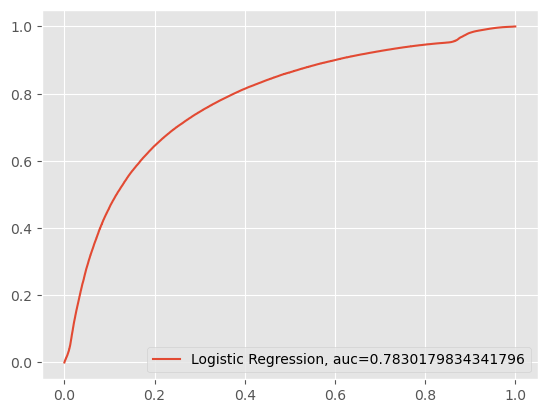

In [164]:
y_pred_prob = y_pred[:,1]
print(y_pred_prob)
false_pos_rt, true_pos_rt, _ = metrics.roc_curve(y_val, y_pred_prob)
auc_score = metrics.roc_auc_score(y_val, y_pred_prob)
plt.plot(false_pos_rt,true_pos_rt,label="Logistic Regression, auc="+str(auc_score))
plt.legend(loc=4)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred_label))
print("Precision:",metrics.precision_score(y_val, y_pred_label))
print("Recall:",metrics.recall_score(y_val, y_pred_label))
print("F1:",metrics.f1_score(y_val, y_pred_label))
print("AUC Score:",auc_score)

## Run Logistic Regression

In [131]:
x_train, x_val = train_new2, test_new2
y_train, y_val = train_plus['reordered'], test_plus['reordered']

lr = LogisticRegression(solver='liblinear',max_iter=1000, class_weight='balanced') 
lr.fit(x_train, y_train)
y_pred = lr.predict(x_val)
print("training is completed")

training is completed


## Evaluate the performance

(2.5, -0.5)

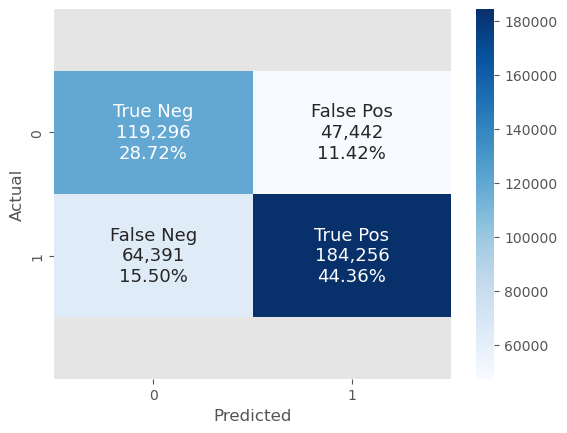

In [132]:
###Confusion Matrix

from sklearn import metrics

cf_matrix = metrics.confusion_matrix(y_val, y_pred)
con_mat = pd.crosstab(y_val, y_pred, rownames=['Actual'], colnames=['Predicted'])
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{:,}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={'size':13})
plt.xlabel('Predicted')
plt.ylabel('Actual')
# fix for mpl bug that cuts off top/bottom of seaborn viz
bottom, top = plt.ylim() # discover the values for bottom and top
bottom += 0.5 # Add 0.5 to the bottom
top -= 0.5 # Subtract 0.5 from the top
plt.ylim(bottom, top) # update the ylim(bottom, top) values

Accuracy: 0.7307726566919845
Precision: 0.7952420823658383
Recall: 0.7410344785981733
F1: 0.7671819213273793
AUC Score: 0.7992857102622118


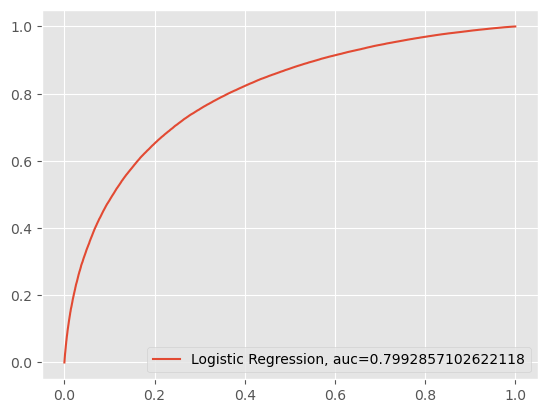

In [133]:
###Confusion Matrix Evaluation Metrics

y_pred_prob = lr.predict_proba(x_val)[::,1]
false_pos_rt, true_pos_rt, _ = metrics.roc_curve(y_val, y_pred_prob)
auc_score = metrics.roc_auc_score(y_val, y_pred_prob)
plt.plot(false_pos_rt,true_pos_rt,label="Logistic Regression, auc="+str(auc_score))
plt.legend(loc=4)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("F1:",metrics.f1_score(y_val, y_pred))
print("AUC Score:",auc_score)

## Feature Importance

(45,)
(45,)
[-1.37668797e-01 -6.14413101e-03 -2.62064344e-04 -2.67924904e-01
  4.57083768e-01 -1.16465303e-02  9.83505610e-03  1.11829253e-01
  5.80218249e-02  2.73029313e+00  1.65199517e-02  3.46382998e-03
 -3.44566994e-02 -3.40832466e-02 -5.24661455e-02 -1.84871017e-02
 -5.89821723e-03  8.05425708e-03  2.76919827e-02 -6.84294579e-02
  1.37036513e-01  8.39090242e-02 -4.14494687e-02 -8.98569556e-03
 -5.40999584e-02  7.39111008e-02  7.13595556e-02 -1.47604298e-01
  2.03154261e-03 -2.96940119e-01 -1.88694535e-01  3.87799209e-02
 -2.38369183e-01 -3.67060437e-02 -3.62399616e-01 -4.17619912e-01
  3.74785263e-02 -3.70392166e-03 -2.62637057e-02 -1.22000029e-01
 -1.23208350e-01 -1.38863443e-01 -1.18662094e-01 -1.13970123e-01
 -2.42555210e-02]
['add_to_cart_order' 'days_since_prior_order' 'up_nb_reordered'
 'up_tot_purchase' 'up_tot_reordered' 'u_mean_dow' 'u_order_no'
 'u_mean_cart' 'u_max_cart' 'p_reorder_ratio' 'p_user' 'up_reorder_ratio'
 'a_reorder_ratio' 'order_dow_1' 'order_dow_2' 'order

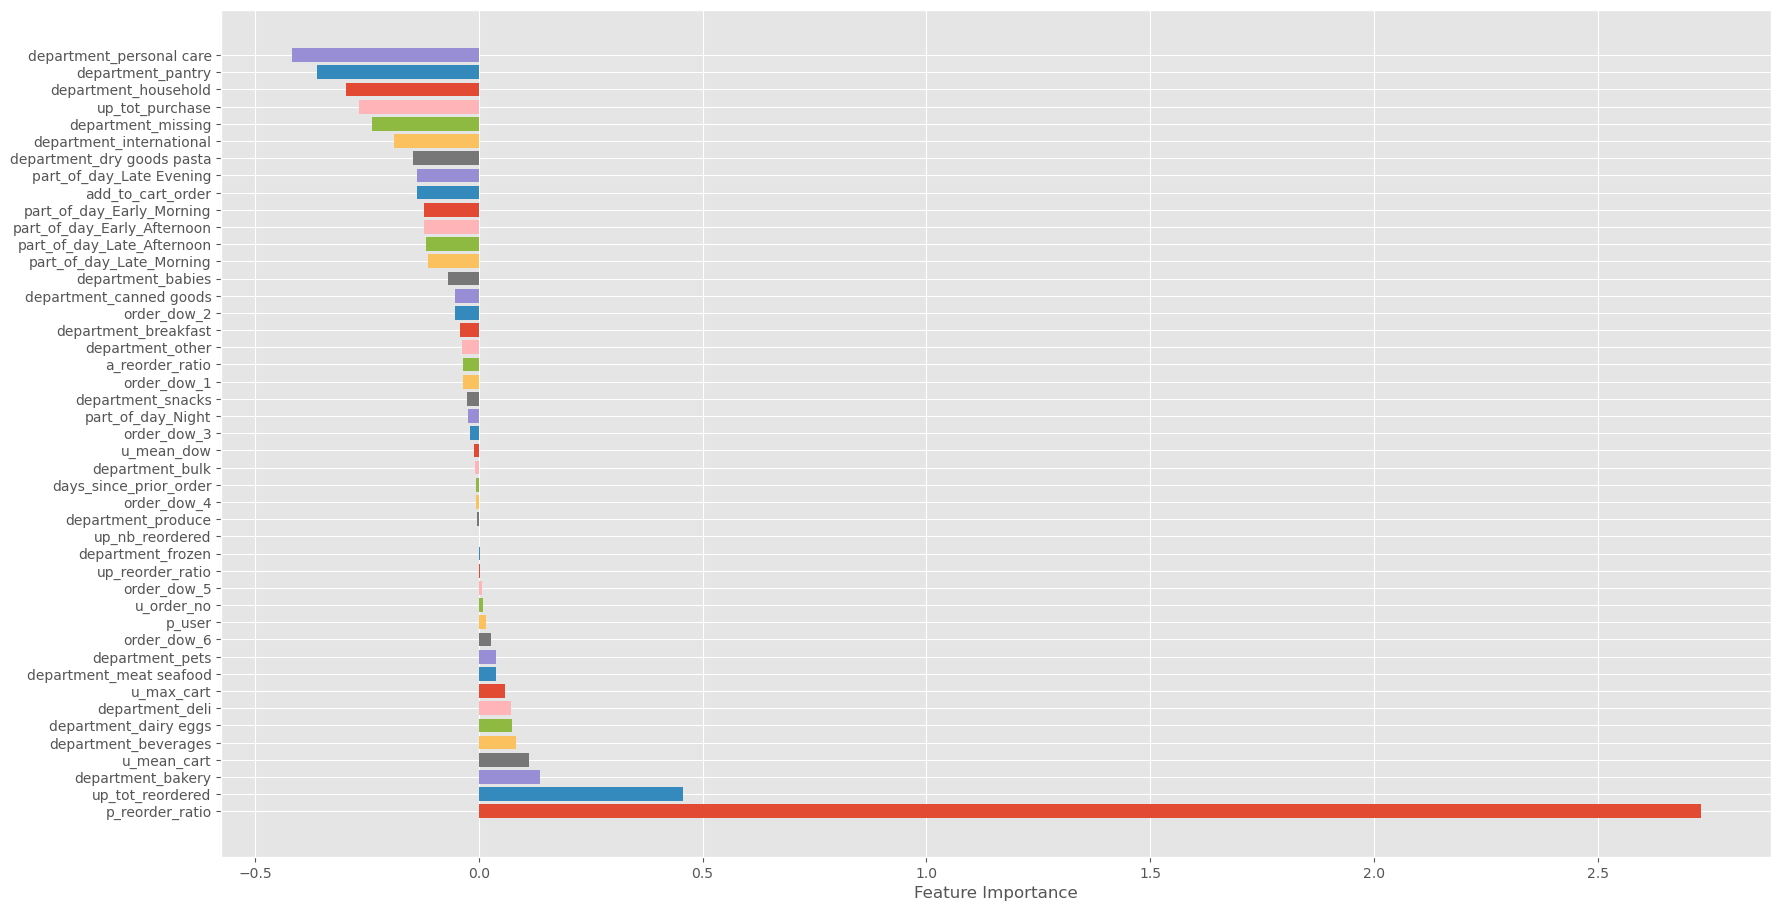

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

title = "Feature Importance"
x = "Importance"
y = "Feature"
feat_importances=lr.coef_[0]
labels = lr.feature_names_in_
plt.style.use('ggplot')
fig, ax = plt.subplots()
fig.set_size_inches(20, 11)
    
    
# importance=np.sort(importance)[::-1]
feat_idx = np.argsort(feat_importances)[::-1]

print(feat_importances.shape)
print(labels.shape)

# feat_importances *= 10000

index = np.arange(len(labels)) + 0.3
bar_width = 0.4

values = np.arange(0, 2500, 500)
value_increment = 1000

for row in range(labels.shape[0]):
    # print(row,' ',index)
    plt.barh(y=index[row], width=feat_importances[feat_idx[row]], tick_label=labels[feat_idx[row]])


plt.xlabel("Feature Importance".format(value_increment))
plt.yticks(index, labels=labels[feat_idx])


# sns.barplot(x=x, y=y, data=feat_importances[feat_idx], label=labels[feat_idx])
# plt.subplots_adjust(left=.4, right=.9)
# plt.title(title+' TOP{0}'.format(n), fontsize=20, alpha=0.5)
# plt.show()

print(feat_importances)
print(labels)

## Feature Coefficient

In [138]:
predictors = lr.feature_names_in_
print(lr.intercept_.shape)
print(lr.coef_[0])
coefficients = lr.coef_[0]
pd.DataFrame(data={'Variable': ['intercept'] + predictors, 'Coefficient':coefficients})

(1,)
[-1.37668797e-01 -6.14413101e-03 -2.62064344e-04 -2.67924904e-01
  4.57083768e-01 -1.16465303e-02  9.83505610e-03  1.11829253e-01
  5.80218249e-02  2.73029313e+00  1.65199517e-02  3.46382998e-03
 -3.44566994e-02 -3.40832466e-02 -5.24661455e-02 -1.84871017e-02
 -5.89821723e-03  8.05425708e-03  2.76919827e-02 -6.84294579e-02
  1.37036513e-01  8.39090242e-02 -4.14494687e-02 -8.98569556e-03
 -5.40999584e-02  7.39111008e-02  7.13595556e-02 -1.47604298e-01
  2.03154261e-03 -2.96940119e-01 -1.88694535e-01  3.87799209e-02
 -2.38369183e-01 -3.67060437e-02 -3.62399616e-01 -4.17619912e-01
  3.74785263e-02 -3.70392166e-03 -2.62637057e-02 -1.22000029e-01
 -1.23208350e-01 -1.38863443e-01 -1.18662094e-01 -1.13970123e-01
 -2.42555210e-02]


,Variable,Coefficient
0,interceptadd_to_cart_order,-0.137669
1,interceptdays_since_prior_order,-0.006144
2,interceptup_nb_reordered,-0.000262
3,interceptup_tot_purchase,-0.267925
4,interceptup_tot_reordered,0.457084
5,interceptu_mean_dow,-0.011647
6,interceptu_order_no,0.009835
7,interceptu_mean_cart,0.111829
8,interceptu_max_cart,0.058022
9,interceptp_reorder_ratio,2.730293


## Stat model

In [139]:
import statsmodels.api as sm

exog = sm.add_constant(x_train)

glm_binom = sm.GLM(y_train, exog, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              reordered   No. Observations:               969232
Model:                            GLM   Df Residuals:                   969187
Model Family:                Binomial   Df Model:                           44
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.3693e+05
Date:                Tue, 06 Dec 2022   Deviance:                   8.7386e+05
Time:                        18:40:13   Pearson chi2:                 2.86e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3595
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Remove Negative Important Feature

In [48]:
drop_list = ['order_dow', 'u_mean_dow']
train_new2 = train_new.drop(drop_list, axis=1)
test_new2 = test_new.drop(drop_list, axis=1)
train_new2.info()
test_new2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969231 entries, 0 to 969230
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   add_to_cart_order       969231 non-null  int64  
 1   order_hour_of_day       969231 non-null  int64  
 2   days_since_prior_order  969231 non-null  float64
 3   up_nb_reordered         969231 non-null  int64  
 4   up_tot_purchase         969231 non-null  int64  
 5   up_tot_reordered        969231 non-null  int64  
 6   u_order_no              969231 non-null  int64  
 7   u_mean_cart             969231 non-null  float64
 8   u_max_cart              969231 non-null  int64  
 9   p_reorder_ratio         969231 non-null  float16
 10  p_user                  969231 non-null  float64
 11  up_reorder_ratio        969231 non-null  float64
 12  a_reorder_ratio         969231 non-null  float16
dtypes: float16(2), float64(4), int64(7)
memory usage: 92.4 MB
<class 'pandas.c

## Re-Run Logistic Regression

In [49]:
x_train, x_val = train_new2, test_new2
y_train, y_val = train_plus['reordered'], test_plus['reordered']

lr = LogisticRegression(solver='liblinear',max_iter=1000, class_weight='balanced') 
lr.fit(x_train, y_train)
y_pred = lr.predict(x_val)
print("training is completed")

training is completed


## Evaluate the performance of the new model

(2.5, -0.5)

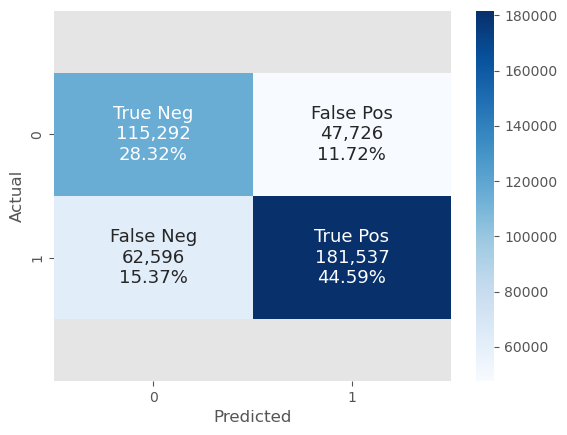

In [50]:
###Confusion Matrix

from sklearn import metrics

cf_matrix = metrics.confusion_matrix(y_val, y_pred)
con_mat = pd.crosstab(y_val, y_pred, rownames=['Actual'], colnames=['Predicted'])
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{:,}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={'size':13})
plt.xlabel('Predicted')
plt.ylabel('Actual')
# fix for mpl bug that cuts off top/bottom of seaborn viz
bottom, top = plt.ylim() # discover the values for bottom and top
bottom += 0.5 # Add 0.5 to the bottom
top -= 0.5 # Subtract 0.5 from the top
plt.ylim(bottom, top) # update the ylim(bottom, top) values

In [141]:
from sklearn.neural_network import MLPClassifier
# X = [[0., 0.], [1., 1.]]
# y = [0, 1]

x_train, x_val = train_new2, test_new2
y_train, y_val = train_plus['reordered'], test_plus['reordered']

clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(5,2), random_state=1, max_iter=10000)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_val)
print('training is completed')

training is completed


In [142]:
y_pred

array([0, 1, 1, ..., 0, 0, 1])

(2.5, -0.5)

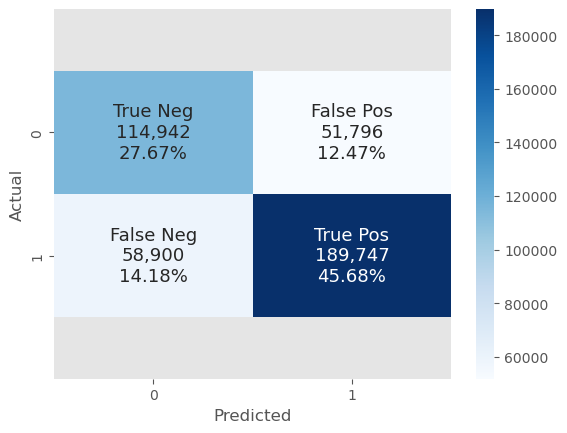

In [143]:
###Confusion Matrix

from sklearn import metrics

cf_matrix = metrics.confusion_matrix(y_val, y_pred)
con_mat = pd.crosstab(y_val, y_pred, rownames=['Actual'], colnames=['Predicted'])
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{:,}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={'size':13})
plt.xlabel('Predicted')
plt.ylabel('Actual')
# fix for mpl bug that cuts off top/bottom of seaborn viz
bottom, top = plt.ylim() # discover the values for bottom and top
bottom += 0.5 # Add 0.5 to the bottom
top -= 0.5 # Subtract 0.5 from the top
plt.ylim(bottom, top) # update the ylim(bottom, top) values

Accuracy: 0.7335098763797441
Precision: 0.7855619910326526
Recall: 0.7631179945867033
F1: 0.7741773597992615
AUC Score: 0.787459856832066


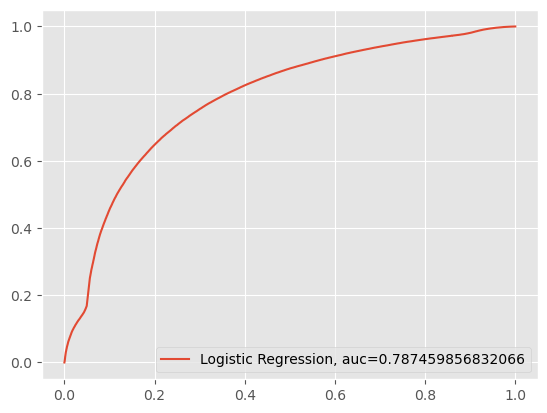

In [144]:
###Confusion Matrix Evaluation Metrics

y_pred_prob = clf.predict_proba(x_val)[:,1]
false_pos_rt, true_pos_rt, _ = metrics.roc_curve(y_val, y_pred_prob)
auc_score = metrics.roc_auc_score(y_val, y_pred_prob)
plt.plot(false_pos_rt,true_pos_rt,label="Logistic Regression, auc="+str(auc_score))
plt.legend(loc=4)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("F1:",metrics.f1_score(y_val, y_pred))
print("AUC Score:",auc_score)